# Your own recommender system

In this task we will take a look at music recommendations.

You will compare iALS with item-based recommendations and a simple bestsellers baseline by NDCG.

# Imports

In [365]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [366]:
%config IPCompleter.greedy=True
%env OPENBLAS_NUM_THREADS=1
import pandas as pd
import implicit
from sklearn.model_selection import train_test_split
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

env: OPENBLAS_NUM_THREADS=1


# Yandex.Music dataset

# Loading dataset

In [367]:
artists = pd.read_json("artists.jsonl", orient='records', lines=True)
print(artists.dtypes)
artists.head(5)

artistId       int64
artistName    object
dtype: object


,artistId,artistName
0,0,Mack Gordon
1,1,Kenny Dorham
2,2,Max Roach
3,3,Francis Rossi
4,4,Status Quo


In [368]:
events = pd.read_csv("events.csv")
print(events.dtypes)
events.head()

userId      int64
artistId    int64
plays       int64
skips       int64
dtype: object


,userId,artistId,plays,skips
0,0,335,1,0
1,0,708,1,0
2,0,710,2,1
3,0,815,1,1
4,0,880,1,1


In [369]:
# statistics
print("users:", len(set(events.userId)))
print("items:", len(set(events.artistId)))
print("interactions:", len(events))
print("density:", len(events) / (len(set(events.userId)) * len(set(events.artistId))))

users: 4999
items: 53031
interactions: 3412504
density: 0.012872420423252307


In [370]:
# most popular artists
(
    events
    .merge(artists)[['artistName', 'plays']]
    .groupby("artistName").sum()
    .sort_values('plays', ascending=False)
    .head(10)
)

,plays
artistName,
Imagine Dragons,43447
Би-2,29415
Баста,27264
Ленинград,26311
Сплин,25062
Queen,24905
Sia,22803
LOBODA,21923
Noize MC,21774


In [371]:
# train / test split
train, test = train_test_split(events, test_size=0.05, random_state=0)
print(train.shape)
print(test.shape)

(3241878, 4)
(170626, 4)


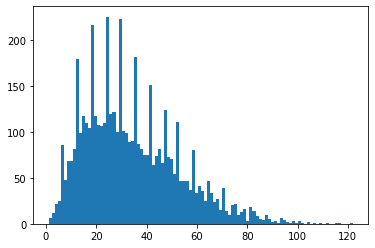

In [372]:
# number of artists per user in the test set
_ = plt.hist(test.groupby('userId').count()['plays'], bins=100)

# Train iALS

Let's say that confidence is `1 + 10 * log2(plays + 1)`

In [373]:
# prepare matrix for implicit library (https://implicit.readthedocs.io/en/latest/models.html)
# item_user (sparse csr_matrix) of item/user/confidence
# csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#     where ``data``, ``row_ind`` and ``col_ind`` satisfy the
#     relationship ``a[row_ind[k], col_ind[k]] = data[k]``.

# item_user_train = sps.csc_matrix((1 + 10 * np.log2(train.plays + 1), (train.artistId, train.userId)))
item_user_train = sps.csr_matrix((1 + 10 * np.log2(train.plays + 1), (train.userId, train.artistId)))
item_user_train

<4999x70818 sparse matrix of type '<class 'numpy.float64'>'
	with 3241878 stored elements in Compressed Sparse Row format>

In [374]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=32, iterations=10, random_state=0)
model.fit(item_user_train)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 16.1 s, sys: 78.7 ms, total: 16.2 s
Wall time: 16.4 s


# Similar artists (via iALS)

Let's find similar artists by cosine between their embeddings

In [375]:
target_artists = artists[artists.artistName.isin(['Coldplay', '50 Cent', 'AC/DC'])]
target_artists

,artistId,artistName
404,404,Coldplay
647,647,50 Cent
33965,33965,AC/DC


In [376]:
artist_to_name = dict(zip(artists.artistId, artists.artistName))
for _, row in target_artists.iterrows():
    print("#############", row.artistName, "#############")
    print(row.artistId)
    pairwise_cosine = (zip(*model.similar_items(row.artistId, N=5)))
    for artist_id, cosine in pairwise_cosine:
        print(artist_to_name[artist_id], cosine)

############# Coldplay #############
404
Coldplay 0.99999994
Lana Del Rey 0.9883556
OneRepublic 0.9833105
Adele 0.9782198
Maroon 5 0.97765636
############# 50 Cent #############
647
50 Cent 1.0
Dr. Dre 0.92830014
2Chainz 0.90787315
Lil Jon 0.8978265
Akon 0.8968366
############# AC/DC #############
33965
AC/DC 1.0
The Offspring 0.95381606
Red Hot Chili Peppers 0.9477411
Nirvana 0.94621986
Metallica 0.94387364


In [377]:
# artist_to_name = dict(zip(artists.artistId, artists.artistName))
# for _, row in target_artists.iterrows():
#     print("#############", row.artistName, "#############")
#     for a, s in model.similar_items(row.artistId, N=5):
#         print(a)
#         print(artist_to_name[a], "\t", s)

# NDCG metric

In [378]:
from sklearn.metrics import ndcg_score

In [379]:
# how ndcg works in sklearn (true scores are used without exponentiation)
print(ndcg_score(y_true=[[  0,   0,   2,   1,   0]], 
                 y_score=[[0.2, 0.1, 0.5, 0.3, 0.4]]))
print((2 / np.log(1 + 1) + 1 / np.log(3 + 1)) / 
      (2 / np.log(1 + 1) + 1 / np.log(2 + 1)))

0.9502344167898358
0.9502344167898358


# NDCG for baseline

__q1: Let's compute NDCG for non-personalized baseline on the test set.__

Let's say that we rank test artists for each user by their global popularity (the sum of plays in the training dataset).

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [380]:
# YOUR CODE HERE
global_pop = train.groupby('artistId')['plays'].sum()  # artistdId --> sum_plays
users = test.groupby('userId')['artistId'].nunique()
users = users.loc[lambda x : x >= 2]  # sers in test with at least 2 artists.
df = test.merge(global_pop.rename('global_pop'), how='inner', left_on='artistId', right_index=True)
# df.sort_values("plays", ascending=False, inplace=True)

In [381]:
df['userId'].nunique()

4997

In [382]:
df = df.loc[df['userId'].isin(users.index)]

In [383]:
df['userId'].nunique()

4994

In [384]:
ndcg =[]

for user_id in users.index:
    y_true = df[df.userId == user_id].plays.to_list()
    y_score = df[df.userId == user_id].global_pop.to_list()
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

In [385]:
np.mean(ndcg)

0.6612094115039636

# NDCG for iALS

__q2: Now let's replace global popularity with iALS prediction for each user.__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [386]:
# prediction for user 100 and item 200 (a simple dot product):
print(model.user_factors[100].dot(model.item_factors[200]))

-0.00018411875


In [387]:
df

,userId,artistId,plays,skips,global_pop
569489,1257,69883,1117,71,312
689468,1525,23612,766,9,4641
1687826,3690,35389,414,73,317
676526,1497,70357,379,123,2337
2196715,4765,37891,368,0,1198
...,...,...,...,...,...
2549524,1097,4049,0,1,2149
2649136,1565,4049,0,1,2149
2580978,1233,4049,0,1,2149
3248054,4222,4049,0,4,2149


In [388]:
# YOUR CODE HERE
ials_pop = []
for _, row in df.iterrows():
    user_id = int(row['userId'])
    artist_id = int(row['artistId'])
    pop = model.user_factors[user_id].dot(model.item_factors[artist_id])
    ials_pop.append(pop)
    

In [389]:
df['ials_pop'] = ials_pop

In [390]:
df

,userId,artistId,plays,skips,global_pop,ials_pop
569489,1257,69883,1117,71,312,0.621763
689468,1525,23612,766,9,4641,1.106542
1687826,3690,35389,414,73,317,0.596063
676526,1497,70357,379,123,2337,1.179524
2196715,4765,37891,368,0,1198,0.676183
...,...,...,...,...,...,...
2549524,1097,4049,0,1,2149,0.594028
2649136,1565,4049,0,1,2149,0.304219
2580978,1233,4049,0,1,2149,0.404207
3248054,4222,4049,0,4,2149,0.933743


In [391]:
ndcg =[]

for user_id in users.index:
    y_true = df[df.userId == user_id].plays.to_list()
    y_score = df[df.userId == user_id].ials_pop.to_list()
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

In [392]:
np.mean(ndcg)

0.7096174535061077

# Jaccard similarities

Let's compute Jaccard similarities for pairs of artists in the training dataset. 

Here're some details:
- Take into account only artists that the user has played at least 3 times (to cut off random plays).
- Compute jacccard similarity only for pairs that have at least 50 common users (to get confident estimates).

__q3: We will use it to recommend similar artists for users in the test set, but first let's find most similar artist to "Maroon 5" (other than "Maroon 5").__

In [393]:
# each user has less than N=1000 artists, so N^2 is not that big
(
    train[train.plays >= 3]
    .groupby("userId").count()
    .sort_values("plays", ascending=False)
    .head(5)
)

,artistId,plays,skips
userId,,,
4689,614,614,614
4575,550,550,550
3121,548,548,548
2266,497,497,497
1168,479,479,479


In [394]:
# YOUR CODE HERE
df_train = train[train.plays >= 3]
target_artists = df_train.artistId.unique()
target_artists

array([ 3818, 36307, 32659, ..., 66367, 20040, 26708])

In [395]:
target_artist_to_users = {id: set(df_train[df_train['artistId'] == id]['userId'].values)
                          for id in target_artists}

In [396]:
from tqdm import tqdm


jaccard_pair = dict()
jaccard = dict()
seen = set()

for i in tqdm(range(len(target_artists))):
    for j in range(i + 1, len(target_artists)):
        
        artist_1 = target_artists[i]
        artist_2 = target_artists[j]
        
        if  artist_1 != artist_2 and (pair not in jaccard_pair):
            
            artist_1_users = target_artist_to_users[artist_1]
            artist_2_users = target_artist_to_users[artist_2]
            
            l_intersect = len(artist_1_users & artist_2_users)
            
            if l_intersect >= 50:
                similarity = l_intersect / (len(artist_1_users) + len(artist_2_users) - l_intersect)
                
                jaccard_pair[(artist_1, artist_2)] = similarity
                jaccard_pair[(artist_2, artist_1)] = similarity
                
                jaccard.setdefault(artist_1, []).append((artist_2, similarity))
                jaccard.setdefault(artist_2, []).append((artist_1, similarity))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28435/28435 [05:04<00:00, 93.31it/s]


In [397]:
maroon5_id = artists[artists.artistName == 'Maroon 5']['artistId'].values[0]
maroon5_id

14803

In [398]:
max_similarity = max(jaccard[maroon5_id], key=lambda tup: tup[1])
max_similarity


(3568, 0.3138075313807531)

In [399]:
artists[artists.artistId == max_similarity[0]]

,artistId,artistName
3568,3568,OneRepublic


# NDCG for item-based collaborative filtering (with Jaccard similarities)

Let's compute our `prediction` for test `item` like follows:
```python
prediction = 0
for history_item, history_plays in user_train_history:
    prediction += jaccard[(history_item, item)] * history_plays
```

__q4: What NDCG do we have for item-based recommendations?__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [400]:
test

,userId,artistId,plays,skips
564228,1244,47785,1,0
3388837,4881,15996,0,1
676253,1496,63240,6,5
549629,1211,1120,6,3
503021,1105,7636,1,0
...,...,...,...,...
3148855,3790,20291,0,1
1352451,2962,38645,1,0
2820055,2357,23579,0,4
2929571,2814,36773,0,2


In [401]:
train_history = dict()
for uid in train.userId.unique():
    train_history[uid] = list(train[train.userId == uid][['artistId', 'plays']].itertuples(index=False, name=None))

In [402]:
preds = []

for _, row_test in df.iterrows():
    
    user_id = int(row_test['userId'])
    
    item = int(row_test['artistId'])

    prediction = 0

    for history_item, history_plays in train_history[user_id]:

        if (item, history_item) in jaccard_pair:
            prediction += jaccard_pair[(item, history_item)] * history_plays

    preds.append(prediction)


df['item_pred'] = preds


In [403]:
ndcg = []

for user_id in users.index:
    y_true = df[df.userId == user_id].plays.to_list()
    y_score = df[df.userId == user_id].item_pred.to_list()
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

In [404]:
np.mean(ndcg)

0.6977879311100313